In [16]:
import json
import csv
import ast
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import re
from datetime import date, datetime
import time
import numpy as np
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.sentiment import SentimentIntensityAnalyzer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import re    # RegEx for removing non-letter characters

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /Users/sonia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Reading files

In [41]:
#fill blanks with empty string
df_csisg = pd.read_csv('2015_2019_filtered_planning_area_csv.csv', encoding='utf-8')
df_csisg.fillna('', inplace=True)
df_csisg.describe()

,uid,year,weight_of_market_share,customer_expectations_score,perceived_overall_quality_score,perceived_value_score,customer_satisfaction_score,customer_loyalty‎_user_trust_score,education,gender,housetype,postal_code
count,548.000000,548.000000,5.480000e+02,548.000000,548.000000,548.000000,548.000000,548.000000,548.00000,548.000000,548.000000,548.000000
mean,3306.394161,2017.045620,9.989826e-01,69.840128,67.442283,67.928573,65.607464,67.308255,5.95073,1.479927,3.209854,573263.465328
std,1875.000251,1.079863,7.512742e-01,11.888300,14.261062,14.061627,12.817330,14.290966,0.93448,0.500053,0.939550,170345.879438
min,45.000000,2016.000000,1.300000e-11,14.897299,14.570975,16.850924,18.805799,15.160309,5.00000,1.000000,1.000000,90018.000000
25%,1781.250000,2016.000000,4.210526e-01,62.938748,63.119000,61.288818,59.979893,62.676268,5.00000,1.000000,3.000000,522841.250000
50%,3143.500000,2017.000000,9.366325e-01,70.337164,70.092639,67.035182,66.577860,68.546784,6.00000,1.000000,3.000000,566375.500000
75%,4792.750000,2018.000000,1.488203e+00,77.777778,74.385697,77.412538,73.353440,75.314341,7.00000,2.000000,4.000000,670621.000000
max,6897.000000,2019.000000,2.900827e+00,96.308404,96.607919,100.000000,96.314126,100.000000,8.00000,2.000000,6.000000,828722.000000


In [8]:
#looking at verbatim_reasons
#there were blank thingies

In [42]:
df_csisg['verbatim_reasons'].isnull().values.any()

False

In [43]:
df_csisg['verbatim_reasons']

0      THEY MAINTAINED THE TRAINS AND STATIONS WELL, ...
1            SELF HELP TOP MACHINE IS VERY USER FRIENDLY
2                THE BUSES ARE CLEAN AND WELL MAINTAINED
3                                                       
4      WAITING TIME IS SHORT, ACCURATE ARRIVAL TIMING...
                             ...                        
543                                                     
544                  JUST CLICK, TAP AND BOOK, VERY EASY
545    THE DRIVERS KNOW THE ROAD VERY WELL WHICH ALLO...
546    THERE ARE LIMITED OPTIONS OF VEHICLES BEING AB...
547                              APP IS SELF EXPLANATORY
Name: verbatim_reasons, Length: 548, dtype: object

In [44]:
#preprocessing
def text_to_words(text):
    ''' Convert text text into a sequence of words '''
    
    # convert to lowercase
    text = text.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
#     # tokenize
#     words = text.split()
#     # remove stopwords
#     words = [w for w in words if w not in stopwords.words("english")]
#     # apply stemming
#     words = [PorterStemmer().stem(w) for w in words]
    # return list
    return text

print("\nOriginal text ->", df_csisg['verbatim_reasons'][0])
print("\nProcessed text ->", text_to_words(df_csisg['verbatim_reasons'][0]))


Original text -> THEY MAINTAINED THE TRAINS AND STATIONS WELL, ALWAYS CLEAN AND WELL KEPT

Processed text -> they maintained the trains and stations well  always clean and well kept


In [45]:
#cleaning df['verbatim_reasons']
df_csisg['verbatim_reasons']= df_csisg['verbatim_reasons'].apply(lambda x: text_to_words(x))

In [46]:
df_csisg['verbatim_reasons'].head()

0    they maintained the trains and stations well  ...
1          self help top machine is very user friendly
2              the buses are clean and well maintained
3                                                     
4    waiting time is short  accurate arrival timing...
Name: verbatim_reasons, dtype: object

# Cleaning Twitter data

In [20]:
# drop missing rows
df = pd.read_csv('Twitter_Data.csv')
df.dropna(axis=0, inplace=True)

# Map tweet categories
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})
# Output first five rows
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive


In [21]:
#cleaning
import re    # RegEx for removing non-letter characters

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *


def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df['clean_text'][0])
print("\nProcessed tweet ->", tweet_to_words(df['clean_text'][0]))


Original tweet -> when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples

Processed tweet -> ['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']


[nltk_data] Downloading package stopwords to /Users/sonia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
#train data

In [23]:
# Apply data processing to each tweet
X = list(map(tweet_to_words, df['clean_text']))

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
After Tokenization & Padding 
 [  42    1  307   66 1726 1119   40 2378    2 1211  205    2  215   32
  155  100   49   69 1068  215   50    3    6  546    3   50 4179    3
 2806    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [24]:
# Convert categorical variable into dummy/indicator variables.
y = pd.get_dummies(df['category'])
# Train and Test split
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
# Extracting validation set from the train set
valid_size=1000
X_valid, y_valid = X_train[-valid_size:], y_train[-valid_size:]
X_test, y_test = X_train[:-valid_size], y_train[:-valid_size]

print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_valid.shape, y_valid.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (114078, 50) (114078, 3)
Validation Set -> (1000, 50) (1000, 3)
Test Set -> (113078, 50) (113078, 3)


In [25]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val*100

In [26]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall

vocab_size = 5000
embedding_size = 32

# Build model
model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Bidirectional(LSTM(32)))
model3.add(Dropout(0.4))
model3.add(Dense(3, activation='softmax'))

print(model3.summary())

# Compile model
model3.compile(loss='categorical_crossentropy', optimizer='adam', 
               metrics=['accuracy', Precision(), Recall()])

# Train model
num_epochs = 1
batch_size = 32
history3 = model3.fit(X_train, y_train,
                      validation_data=(X_valid, y_valid),
                      batch_size=batch_size, epochs=num_epochs)

# Evaluate model on the test set
loss, accuracy, precision, recall = model3.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('CNN + LSTM Accuracy  : {:.2f}'.format(100 * accuracy), '%')
print('CNN + LSTM Precision : {:.2f}'.format(100 * precision), '%')
print('CNN + LSTM Recall    : {:.2f}'.format(100 * recall), '%')
print('CNN + LSTM F1 Score  : {:.2f}'.format(f1_score(precision, recall)), '%')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 32)            160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 179,939
Trainable params: 179,939
Non-trainable params: 0
__________________________________________________

In [ ]:
#predict class

In [27]:
# from keras.models import load_model

# # Load model
# model = load_model('best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model3.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
#     print('The predicted sentiment is', sentiment_classes[yt[0]])  
    return sentiment_classes[yt[0]]

# Counting polarity

In [47]:
def sentiment_text(df,col):
    sent = []
    for t in df[col]:
        sent.append(predict_class([t]))
    df['sentiment'] = sent

In [48]:
#LSTM sentiment

stop = stopwords.words('english')
#include NA, na, nil, Nil, NIL, Na
newStopWords = ['NA','na','Na','nil','Nil','NIL']
stop.extend(newStopWords)
sentiment_text(df_csisg,'verbatim_reasons')



In [ ]:
#df_csisg.to_csv("CSISG labelled with sentiments LSTM.csv")

In [49]:
len(df_csisg["verbatim_reasons"])

548

In [50]:
df_csisg["sentiment"].value_counts()

Positive    281
Neutral     238
Negative     29
Name: sentiment, dtype: int64

<BarContainer object of 1 artists>

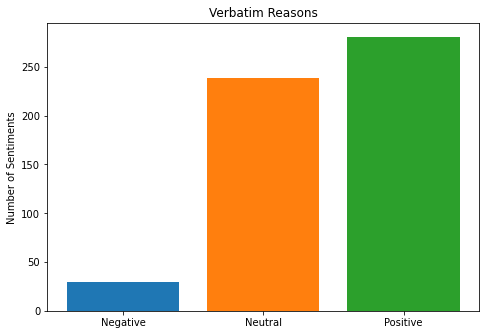

In [51]:
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
ax.set_title("Verbatim Reasons")
ax.set_ylabel('Sentiments')
ax.set_ylabel('Number of Sentiments')
ax.bar("Negative", len(df_csisg[df_csisg["sentiment"]=="Negative"]))
ax.bar("Neutral", len(df_csisg[df_csisg["sentiment"]=="Neutral"]))
ax.bar("Positive", len(df_csisg[df_csisg["sentiment"]=="Positive"]))

In [52]:
def word_cloud(data, stopword, cat):

    message = data[cat].tolist()

    text = " ".join(list(message))

    wc = WordCloud(stopwords = stopword, background_color='white').generate(text)

    print(f"========================{cat}========================")
    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()
    print('\n')

========================verbatim_reasons========================


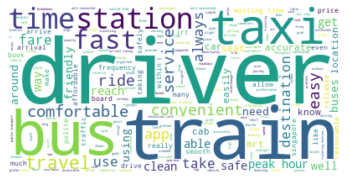

In [53]:
word_cloud(df_csisg, stop,"verbatim_reasons")

In [54]:
def wc_pos(data, stopword, col, text_col):
    t = data[data[col]=='Positive']

    message = t[text_col].tolist()
    
    text = " ".join(list(message))

    wc = WordCloud(stopwords = stopword, background_color='white').generate(text)

    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()
    print('\n')

In [55]:
def wc_neg(data, stopword, col, text_col):
    t = data[data[col]=='Negative']

    message = t[text_col].tolist()
    
    text = " ".join(list(message))

    wc = WordCloud(stopwords = stopword, background_color='white').generate(text)

    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()
    print('\n')

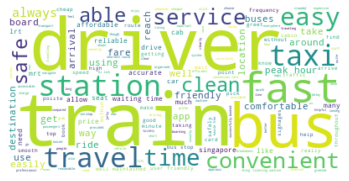

In [58]:
wc_pos(df_csisg, stop,
       'sentiment',
       'verbatim_reasons')

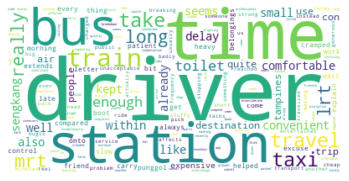

In [59]:
wc_neg(df_csisg, stop,
       'sentiment',
       'verbatim_reasons')